### Contents <a class="anchor" id="sections"></a>

- [Part 1. Reading Data](#section1)
- [Part 2. Preprocessing Data](#section2)
- [Part 3. Data Augmentation](#section3)
- [Part 4. Feature Preprocessing](#section4)
- [Part 5. EDA](#section5)
- [Part 6. GEO](#section6)

### Part 1. Reading Data <a class="anchor" id="section1"></a>

- `ref: Stolen Animals January 2022.csv`

In [1]:
%config InlineBackend.figure_format = 'retina'

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import folium
import squarify
from pywaffle import Waffle

plt.rcParams['figure.figsize'] = (8, 6)
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/Stolen Animals January 2022.csv')

# DataFrame shape
df.shape

(4712, 6)

In [3]:
df.head(3)

,Count of Stolen Animals,Type of Animal,Borough,Type Of Offence,Animal Recovered,Year and Month
0,1,Dog,Lambeth,Theft and Handling,Not Recovered,Jan-2010
1,1,Dog,Islington,Violence Against the Person,Not Recovered,Jan-2010
2,1,Dog,Croydon,Robbery,Not Recovered,Jan-2010


### Part 2. Preprocessing Data <a class="anchor" id="section2"></a>

In [4]:
# Check DataFrame for missing data
df.isnull().sum()

Count of Stolen Animals    0
Type of Animal             0
Borough                    0
Type Of Offence            0
Animal Recovered           0
Year and Month             0
dtype: int64

In [5]:
# View DataFrame columns
for x in df.columns: print(x)

Count of Stolen Animals
Type of Animal
Borough
Type Of Offence
Animal Recovered
Year and Month


In [6]:
# Rename DataFrame columns
df.columns = ['Total Stolen', 'Animal', 'Borough', 'Offence', 'Recovered', 'Date']
df.head(3)

,Total Stolen,Animal,Borough,Offence,Recovered,Date
0,1,Dog,Lambeth,Theft and Handling,Not Recovered,Jan-2010
1,1,Dog,Islington,Violence Against the Person,Not Recovered,Jan-2010
2,1,Dog,Croydon,Robbery,Not Recovered,Jan-2010


In [7]:
# Reorder DataFrame columns
df = df[['Borough', 'Offence', 'Animal', 'Total Stolen', 'Recovered', 'Date']]
df.head(3)

,Borough,Offence,Animal,Total Stolen,Recovered,Date
0,Lambeth,Theft and Handling,Dog,1,Not Recovered,Jan-2010
1,Islington,Violence Against the Person,Dog,1,Not Recovered,Jan-2010
2,Croydon,Robbery,Dog,1,Not Recovered,Jan-2010


### Part 3. Data Augmentation <a class="anchor" id="section3"></a>

#### 3-1. Feature: Borough - New Feature: Location

- `ref: boroughinfo.csv`

In [8]:
# London borough csv file
borough_data = pd.read_csv('data/boroughinfo.csv', encoding='ISO-8859-1')
borough_data.head(3)

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015",...,Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800.0,5326.0,290.0,30.3,43.2,11.4,73.1,...,6.0,5.6,NaN,2.6,129.0,NaN,NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,Outer London,209000.0,78188.0,3611.0,57.9,32.9,27.2,63.1,...,7.1,3.1,28.5,7.3,228.0,Lab,0.0,100.0,0.0,36.5
2,E09000003,Barnet,Outer London,389600.0,151423.0,8675.0,44.9,37.3,21.1,64.9,...,7.4,2.8,20.7,6.0,134.0,Cons,50.8,NaN,1.6,40.5


In [9]:
# Isolate columns required 
borough_data = borough_data[['Area_name', 'Inner/_Outer_London']]

# Remove rows with null data
borough_data.dropna(inplace=True)

# Rename columns
borough_data.columns = ['Borough', 'Location']
borough_data.head(3)

,Borough,Location
0,City of London,Inner London
1,Barking and Dagenham,Outer London
2,Barnet,Outer London


In [10]:
# Add Location column to original DataFrame (merge on Borough column)
df = pd.merge(df, borough_data, on=['Borough'], how='left')
df.head(3)

,Borough,Offence,Animal,Total Stolen,Recovered,Date,Location
0,Lambeth,Theft and Handling,Dog,1,Not Recovered,Jan-2010,Inner London
1,Islington,Violence Against the Person,Dog,1,Not Recovered,Jan-2010,Inner London
2,Croydon,Robbery,Dog,1,Not Recovered,Jan-2010,Outer London


#### 3-2. Feature: Recovered - New Feature: Total Recovered 

In [11]:
# Create new DataFrame & isolate values needed 
new_df = df.loc[df['Recovered']=='Recovered']

# Create a Total Recovered column
df['Total Recovered'] = new_df['Total Stolen']

# Replace NaN values with 0
df['Total Recovered'] = df['Total Recovered'].fillna(0)

# Change column Dtype to int
df['Total Recovered'] = df['Total Recovered'].astype(int)

df.head(3)

,Borough,Offence,Animal,Total Stolen,Recovered,Date,Location,Total Recovered
0,Lambeth,Theft and Handling,Dog,1,Not Recovered,Jan-2010,Inner London,0
1,Islington,Violence Against the Person,Dog,1,Not Recovered,Jan-2010,Inner London,0
2,Croydon,Robbery,Dog,1,Not Recovered,Jan-2010,Outer London,0


#### 3-3. Feature: Date - New Features: Month, Year

In [12]:
# Replace hyphen with whitespace
df['Date'] = df['Date'].str.replace(r'-', ' ', regex=True)

# Create a new DataFrame & isolate values needed - Date column split into two seperate columns
new_df = df['Date'].str.split(' ', n=1, expand=True)
new_df.head(3)

,0,1
0,Jan,2010
1,Jan,2010
2,Jan,2010


In [13]:
# Add month column to original DataFrame
df['Month'] = new_df[0]
  
# Add year column to original DataFrame
df['Year'] = new_df[1]

# Drop Date column from original DataFrame
df.drop(columns = ['Date'], inplace=True)

In [14]:
# Reorder DataFrame columns
df = df[['Borough', 'Location', 'Offence', 
         'Animal', 'Total Stolen', 'Recovered', 
         'Total Recovered', 'Month', 'Year']]
df.head(3)

,Borough,Location,Offence,Animal,Total Stolen,Recovered,Total Recovered,Month,Year
0,Lambeth,Inner London,Theft and Handling,Dog,1,Not Recovered,0,Jan,2010
1,Islington,Inner London,Violence Against the Person,Dog,1,Not Recovered,0,Jan,2010
2,Croydon,Outer London,Robbery,Dog,1,Not Recovered,0,Jan,2010


### Part 4. Feature Preprocessing <a class="anchor" id="section4"></a>

#### 4-1. Feature: Borough

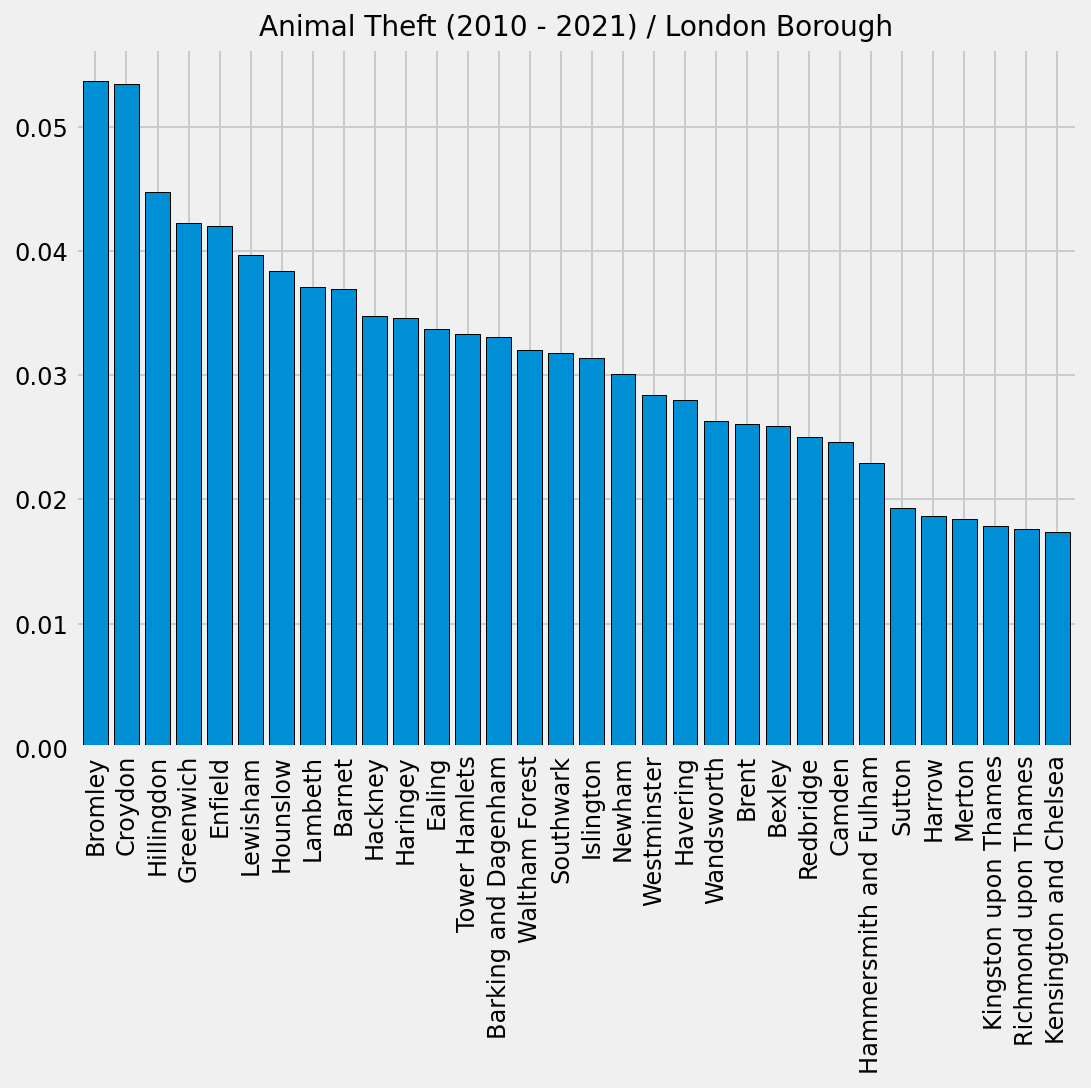

In [15]:
# Plot
df['Borough'].value_counts(normalize=True).plot(kind='bar', ec='black', width=.8)
plt.xticks(fontweight=12, fontsize=12)
plt.yticks(fontweight=12, fontsize=12)
plt.title('Animal Theft (2010 - 2021) / London Borough', fontsize=14)
plt.show()

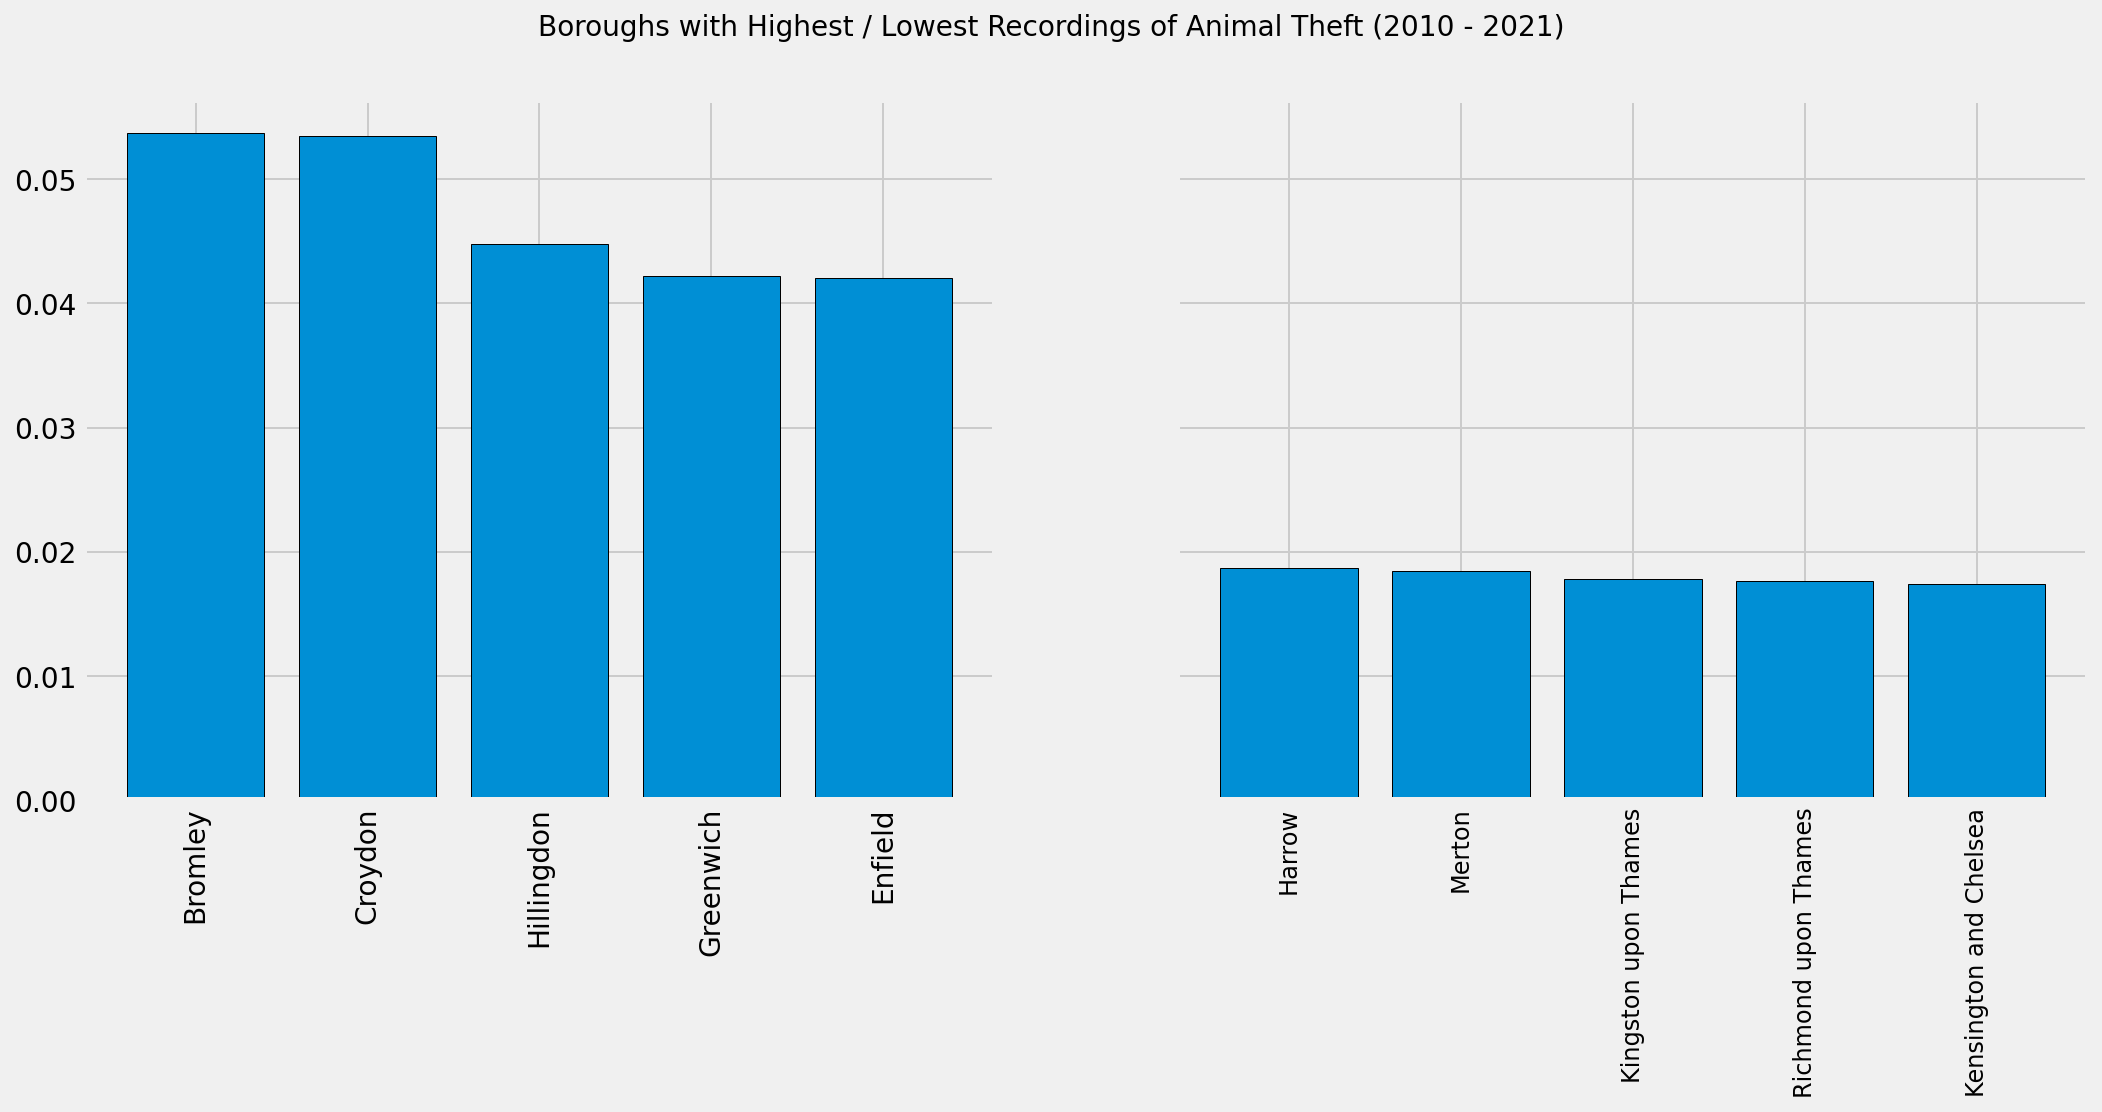

In [16]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6))

# Plot
df['Borough'].value_counts(normalize=True).head().plot(kind='bar', ec='black', width=.8,  ax=ax)
plt.xticks(fontweight=12, fontsize=12)
plt.yticks(fontweight=12, fontsize=12)

# Plot
df['Borough'].value_counts(normalize=True).tail().plot(kind='bar', ec='black', width=.8,  ax=ax2)
plt.xticks(fontweight=12, fontsize=12)
plt.yticks(fontweight=12, fontsize=12)
fig.suptitle('Boroughs with Highest / Lowest Recordings of Animal Theft (2010 - 2021)', fontsize=14)
plt.show()

#### 4-2. Feature: Location

In [17]:
round(df['Location'].value_counts(normalize=True) * 100, 2)

Outer London    60.74
Inner London    39.26
Name: Location, dtype: float64

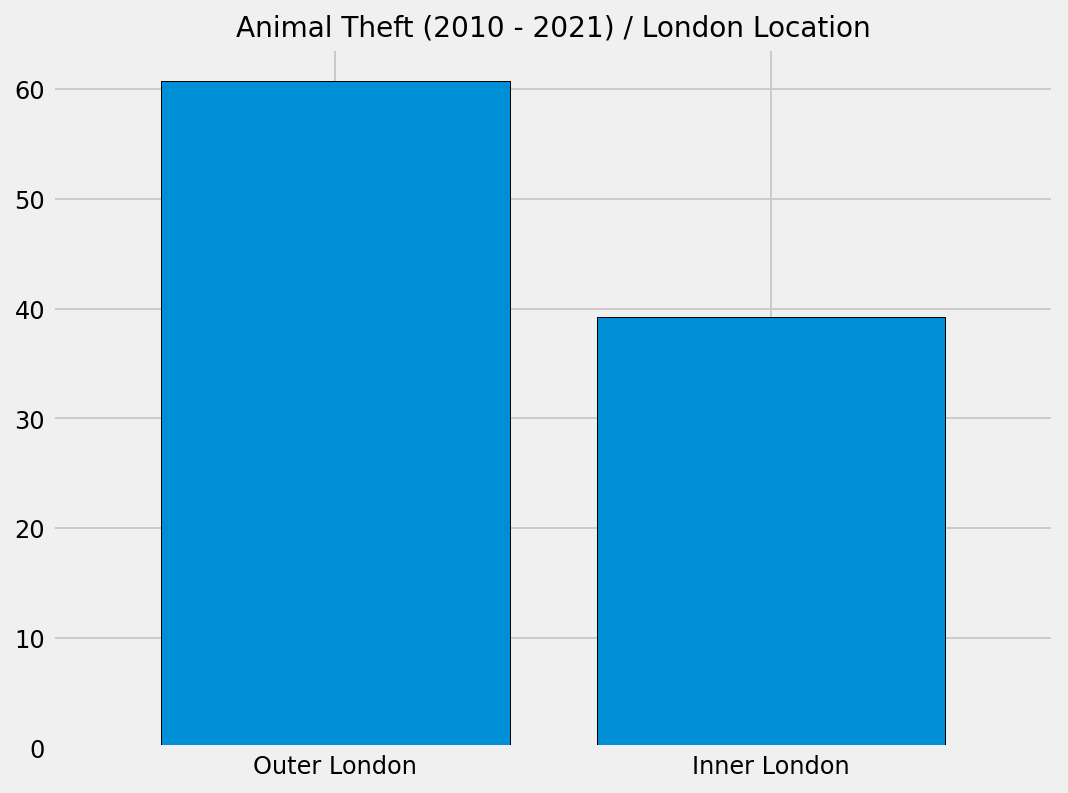

In [18]:
round(df['Location'].value_counts(normalize=True) * 100, 2).plot(kind='bar', ec='black', width=.8)
plt.xticks(rotation=0, fontweight=12, fontsize=12)
plt.yticks(fontweight=12, fontsize=12)
plt.title('Animal Theft (2010 - 2021) / London Location', fontsize=14)
plt.show()

#### 4-3. Feature: Offence

In [19]:
# Offence values
for i in df['Offence'].unique(): print(i)

Theft and Handling
Violence Against the Person
Robbery
Burglary
Other Notifiable Offences
Criminal Damage
Fraud or Forgery
Sexual Offences


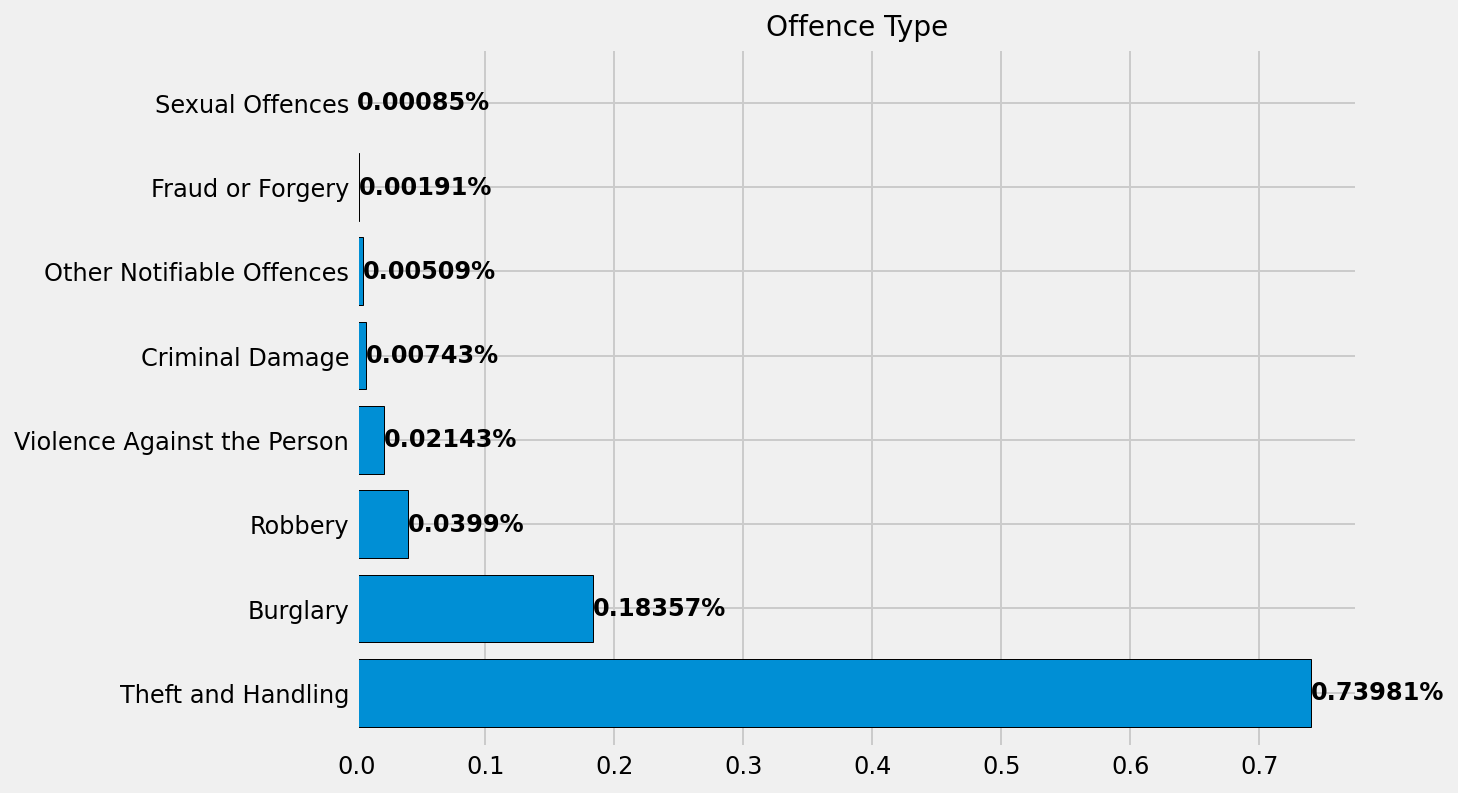

In [20]:
# Plot
df['Offence'].value_counts(normalize=True).plot(kind='barh', ec='black', width=.8)
plt.xticks(fontweight=12, fontsize=12)
plt.yticks(fontweight=12, fontsize=12)
plt.title('Offence Type', fontweight=14, fontsize=14)
for i, v in enumerate(df['Offence'].value_counts(normalize=True)):
    plt.text(v, i, str(round(v, 5))+'%', color='black', ha='left', va='center', fontsize=12, fontweight='bold')
plt.show()

In [21]:
# Isolate offences to keep
offences = ['Theft and Handling', 'Robbery', 'Burglary']

# Drop other offences from DataFrame
df = df[df['Offence'].isin(offences)].copy()

# Merge isolated offences into one 'Theft'
df.loc[df['Offence'] == 'Theft and Handling', 'Offence'] = 'Theft'
df.loc[df['Offence'] == 'Robbery', 'Offence'] = 'Theft'
df.loc[df['Offence'] == 'Burglary', 'Offence'] = 'Theft'

# Column value counts
df['Offence'].value_counts()

Theft    4539
Name: Offence, dtype: int64

In [22]:
# Drop Offence column from DataFrame
df.drop(columns = ['Offence'], inplace = True)

In [23]:
df.head()

,Borough,Location,Animal,Total Stolen,Recovered,Total Recovered,Month,Year
0,Lambeth,Inner London,Dog,1,Not Recovered,0,Jan,2010
2,Croydon,Outer London,Dog,1,Not Recovered,0,Jan,2010
3,Croydon,Outer London,Dog,1,Not Recovered,0,Jan,2010
4,Barking and Dagenham,Outer London,Dog,1,Not Recovered,0,Jan,2010
5,Sutton,Outer London,Dog,1,Not Recovered,0,Jan,2010


#### 4-4. Feature: Animal

- `Isolate data for dog theft`

In [24]:
# Column values
for i in df['Animal'].unique(): print(i)

Dog
Mammal (exc Cat and Dog)
Bird
Cat
Fish
Reptile
Insect
BIrd
Arachnid
cat
Amphibian
mammal (exc Cat and Dog)


In [25]:
# Clean column values
df.loc[df['Animal'] == 'cat', 'Animal'] = 'Cat'
df.loc[df['Animal'] == 'mammal (exc Cat and Dog)', 'Animal'] = 'Mammal (exc Cat and Dog)'
df.loc[df['Animal'] == 'Mammal (exc Cat and Dog)', 'Animal'] = 'Mammal (other)'
df.loc[df['Animal'] == 'BIrd', 'Animal'] = 'Bird'

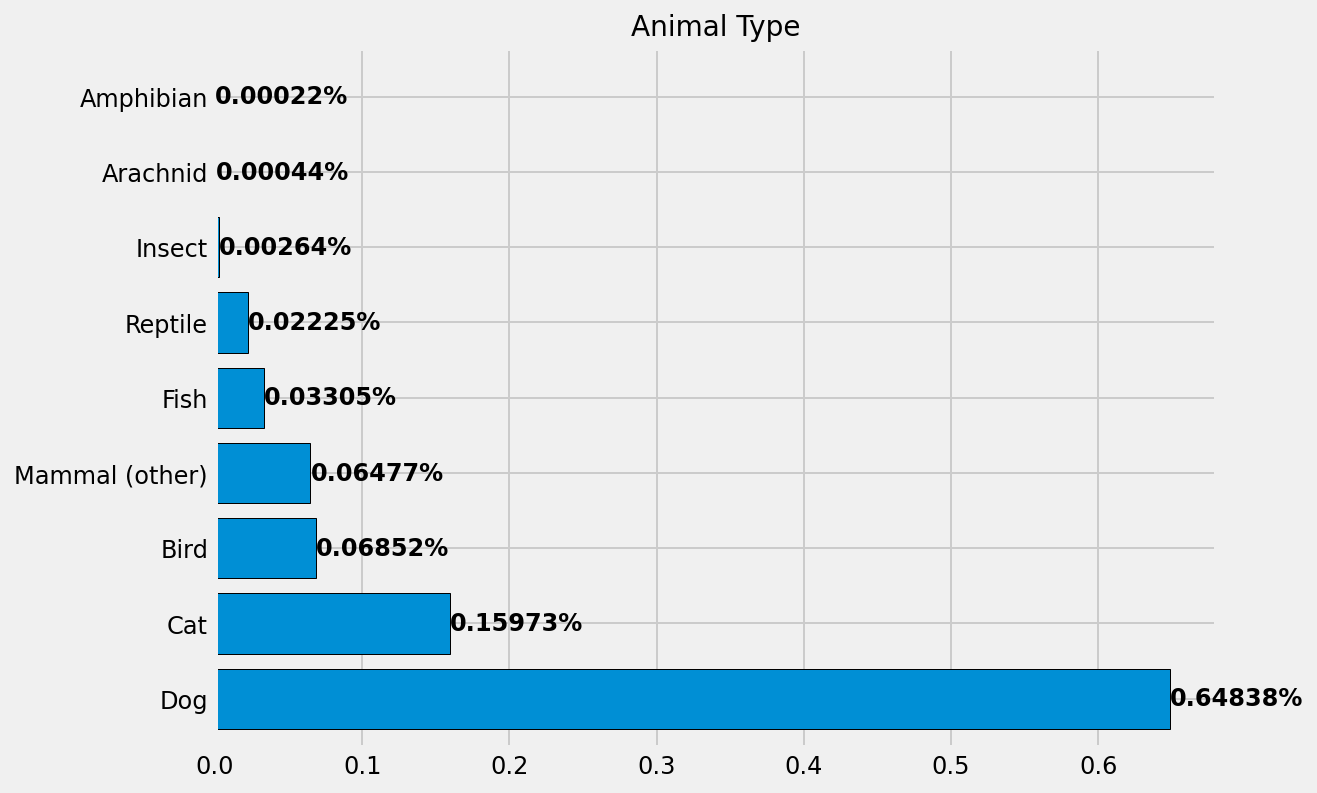

In [26]:
# Plot
df['Animal'].value_counts(normalize=True).plot(kind='barh', ec='black', width=.8)
plt.xticks(fontweight=12, fontsize=12)
plt.yticks(fontweight=12, fontsize=12)
plt.title('Animal Type', fontweight=14, fontsize=14)
for i, v in enumerate(df['Animal'].value_counts(normalize=True)):
    plt.text(v, i, str(round(v, 5))+'%', color='black', ha='left', va='center', fontsize=12, fontweight='bold')
plt.show()

In [27]:
# Isolate values
animal = ['Dog']

# Drop other animals from DataFrame
df = df[df['Animal'].isin(animal)]

# Column value counts
df['Animal'].value_counts()

Dog    2943
Name: Animal, dtype: int64

In [28]:
# Drop animal column from DataFrame
df.drop(columns=['Animal'], inplace=True)

In [29]:
# Reset DataFrame index
df.reset_index(drop=True, inplace=True)

In [30]:
df.head(3)

,Borough,Location,Total Stolen,Recovered,Total Recovered,Month,Year
0,Lambeth,Inner London,1,Not Recovered,0,Jan,2010
1,Croydon,Outer London,1,Not Recovered,0,Jan,2010
2,Croydon,Outer London,1,Not Recovered,0,Jan,2010


#### 4-5. Total Stolen

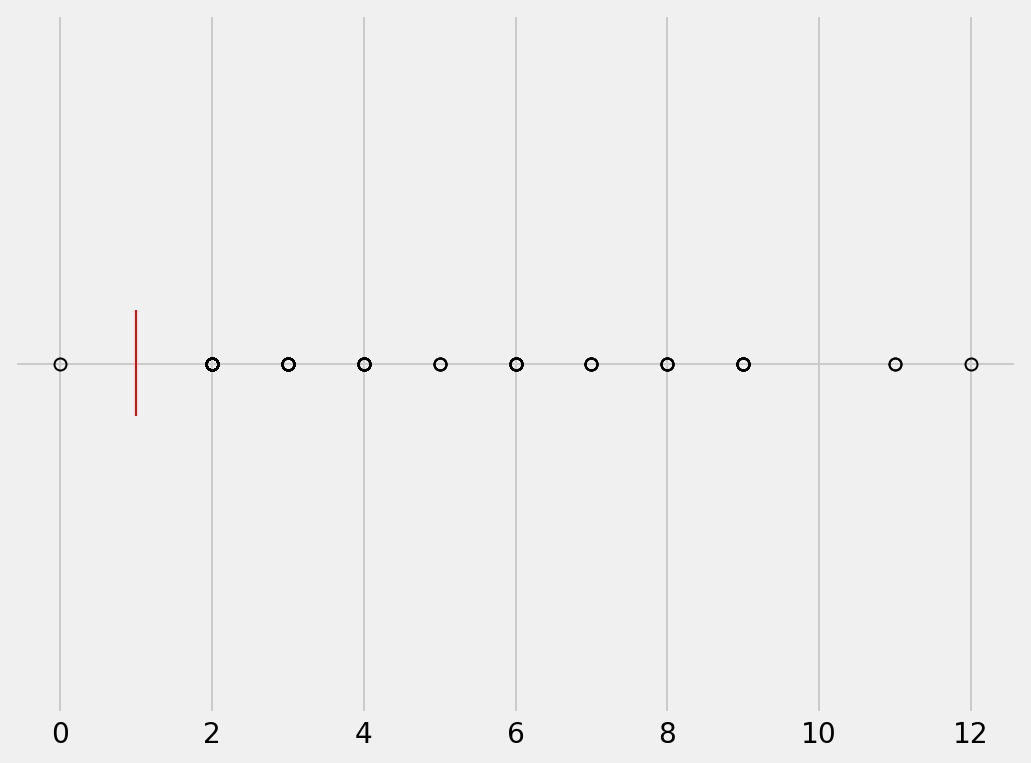

In [31]:
# Check for outliers
df['Total Stolen'].plot(kind='box', vert=False, color='red')
plt.xticks(fontweight=14, fontsize=14)
plt.yticks(visible=False)
plt.show()

In [32]:
df.loc[df['Total Stolen'] > 8].sort_values('Total Stolen')

,Borough,Location,Total Stolen,Recovered,Total Recovered,Month,Year
108,Lewisham,Inner London,9,Not Recovered,0,Apr,2010
142,Lambeth,Inner London,9,Not Recovered,0,May,2010
209,Havering,Outer London,9,Not Recovered,0,Aug,2010
664,Croydon,Outer London,9,Not Recovered,0,Jul,2012
1404,Hillingdon,Outer London,9,Not Recovered,0,Jun,2016
1442,Redbridge,Outer London,9,Not Recovered,0,Aug,2016
1962,Redbridge,Outer London,9,Not Recovered,0,Dec,2018
2553,Havering,Outer London,9,Not Recovered,0,Jan,2021
425,Lambeth,Inner London,11,Not Recovered,0,May,2011
1839,Camden,Inner London,11,Not Recovered,0,Jun,2018


#### 4-6. Feature: Recovered

In [33]:
# Column value counts
round(df['Recovered'].value_counts(normalize=True) * 100, 2)

Not Recovered    87.12
Recovered        12.88
Name: Recovered, dtype: float64

#### 4-7. Feature: Total Recovered

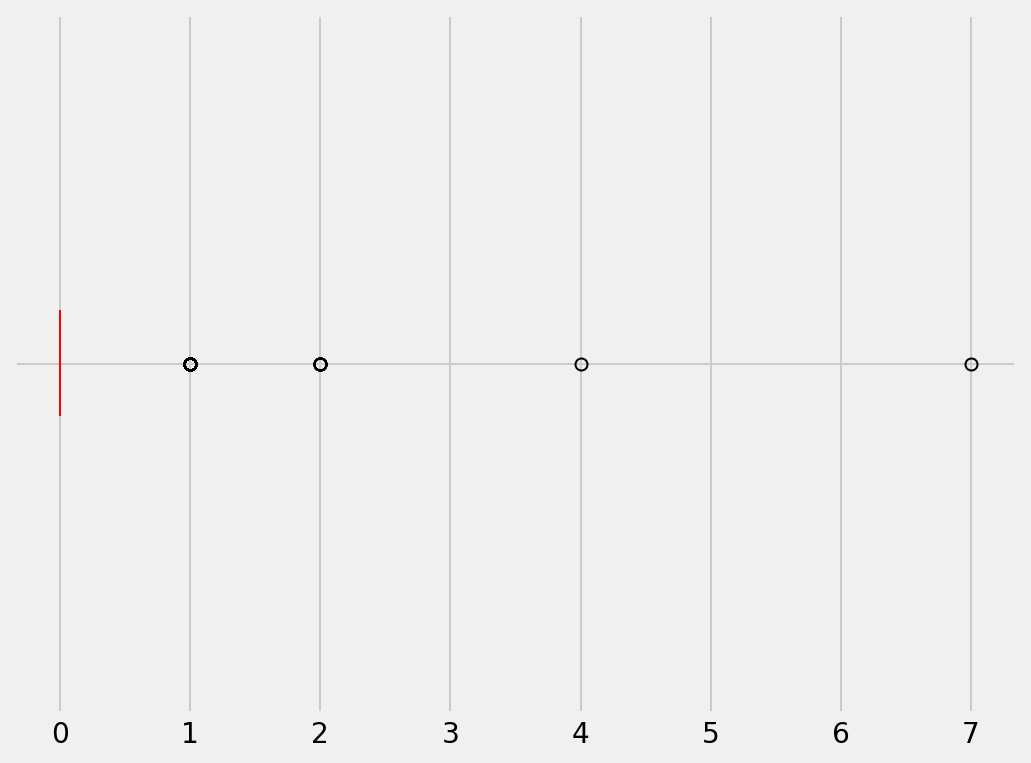

In [34]:
# Check for outliers
df['Total Recovered'].plot(kind='box', vert=False, color='red')
plt.xticks(fontweight=14, fontsize=14)
plt.yticks(visible=False)
plt.show()

In [35]:
df.loc[df['Total Recovered'] >= 2].sort_values('Total Recovered')

,Borough,Location,Total Stolen,Recovered,Total Recovered,Month,Year
519,Hillingdon,Outer London,2,Recovered,2,Oct,2011
1346,Newham,Inner London,2,Recovered,2,Feb,2016
2208,Barking and Dagenham,Outer London,2,Recovered,2,Oct,2019
2552,Enfield,Outer London,2,Recovered,2,Jan,2021
2807,Lambeth,Inner London,2,Recovered,2,Sep,2021
2884,Hillingdon,Outer London,2,Recovered,2,Dec,2021
972,Barking and Dagenham,Outer London,4,Recovered,4,Apr,2014
1264,Hillingdon,Outer London,7,Recovered,7,Oct,2015


#### 4-8. Feature: Month / Year

In [36]:
# Month unique values
for i in df['Month'].unique(): print(i, end=', ')

Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec, 

In [37]:
monthsDict = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
             'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

# Map dictionary to Month column values
df['Month'] = df['Month'].map(monthsDict)

In [38]:
# Month unique values II
for i in df['Month'].unique(): print(i, end=', ')

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Borough          2943 non-null   object
 1   Location         2943 non-null   object
 2   Total Stolen     2943 non-null   int64 
 3   Recovered        2943 non-null   object
 4   Total Recovered  2943 non-null   int64 
 5   Month            2943 non-null   int64 
 6   Year             2943 non-null   object
dtypes: int64(3), object(4)
memory usage: 161.1+ KB


In [40]:
# Year unique values
for i in df['Year'].unique(): print(i, end=', ')

2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 

In [41]:
# Isolate 2022
y = ['2022']

# Drop 2022 data from DataFrame
df = df[~df['Year'].isin(y)]

In [42]:
# Sort DataFrame
df.sort_values(by=['Year', 'Month'] , ascending=True, inplace=True)

In [43]:
display(df.head(3), df.tail(3))

,Borough,Location,Total Stolen,Recovered,Total Recovered,Month,Year
0,Lambeth,Inner London,1,Not Recovered,0,1,2010
1,Croydon,Outer London,1,Not Recovered,0,1,2010
2,Croydon,Outer London,1,Not Recovered,0,1,2010


,Borough,Location,Total Stolen,Recovered,Total Recovered,Month,Year
2907,Havering,Outer London,1,Not Recovered,0,12,2021
2908,Havering,Outer London,1,Not Recovered,0,12,2021
2909,Greenwich,Outer London,1,Not Recovered,0,12,2021


### Part 5. EDA <a class="anchor" id="section5"></a>

#### Q 5-1.  What is the worst month for theft?

In [44]:
df.groupby('Month').sum()

,Total Stolen,Total Recovered
Month,,
1,227,17
2,200,34
3,269,34
4,221,30
5,312,30
6,319,32
7,294,44
8,310,31
9,277,40


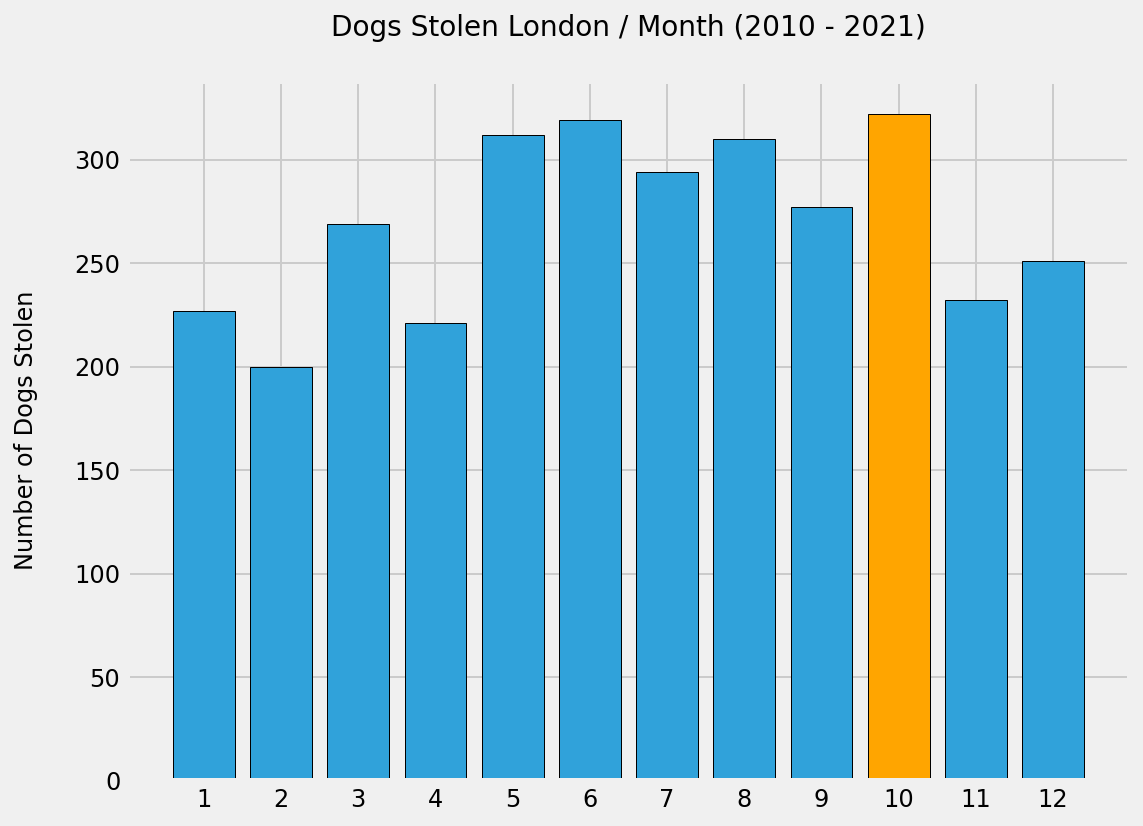

In [45]:
# Groupby - compute sum of int columns
results = df.groupby('Month').sum()

# Match Month values to Month groupby results
months = [month for month, df in df.groupby('Month')]

# Control color for highest Total Stolen value
colors = np.where(results['Total Stolen']==results['Total Stolen'].max(), 'orange','#30a2da')

# Plot
plt.bar(months, results['Total Stolen'], ec='black', width=.8, color=colors)
plt.xticks(months, fontweight=12, fontsize=12)
plt.yticks(fontweight=12, fontsize=12)
plt.ylabel('Number of Dogs Stolen\n', fontweight=12, fontsize=12)
plt.ticklabel_format(axis='y', style='plain')
plt.title('Dogs Stolen London / Month (2010 - 2021)\n', fontsize=14)
plt.show()

#### Q 5-2. What was the worst year for theft?

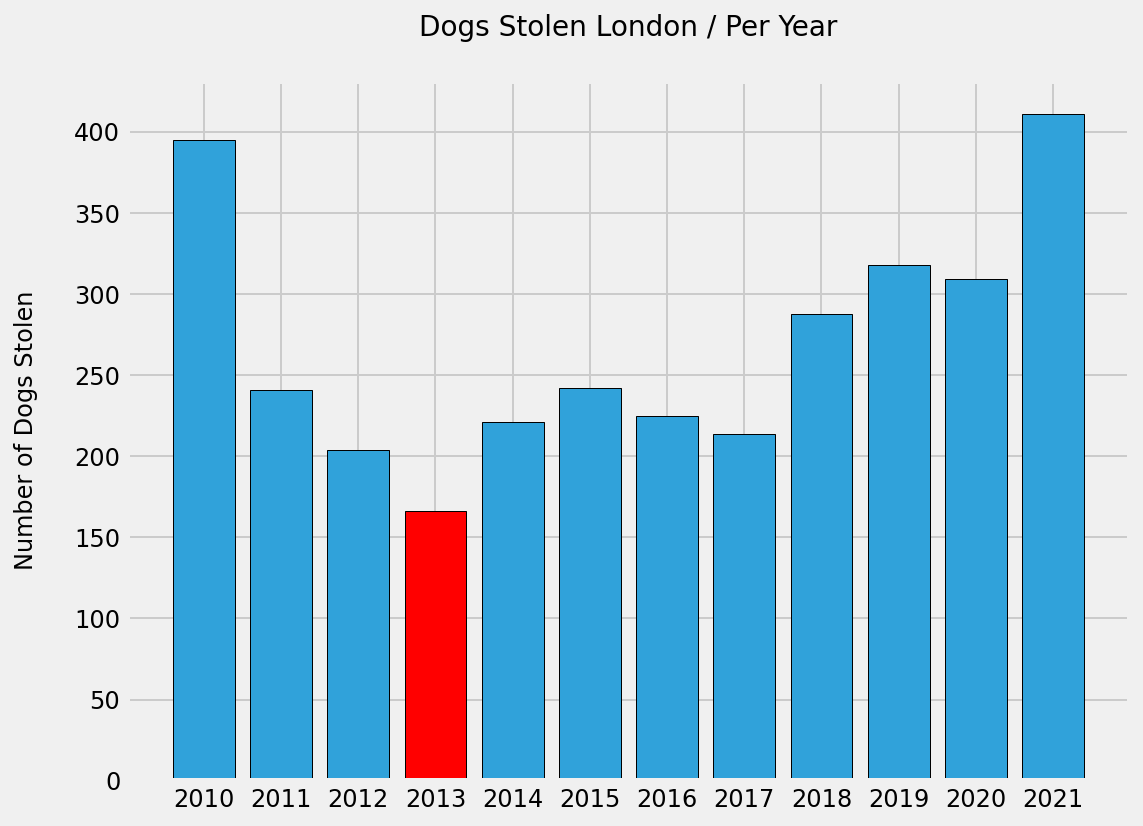

In [46]:
# Groupby - compute sum of int columns
results = df.groupby('Year').sum()

# Match Year values to Year groupby results
years = [year for year, df in df.groupby('Year')]

# Control color for lowest Total Stolen value
colors = np.where(results['Total Stolen']==results['Total Stolen'].min(), 'red','#30a2da')

# Plot
plt.bar(years, results['Total Stolen'], ec='black', width=.8, color=colors)
plt.xticks(years, fontweight=12, fontsize=12)
plt.yticks(fontweight=12, fontsize=12)
plt.ylabel('Number of Dogs Stolen\n', fontweight=12, fontsize=12)
plt.ticklabel_format(axis='y', style='plain')
plt.title('Dogs Stolen London / Per Year\n', fontsize=14)
plt.show()

#### Q 5-3. London borough with the highest recovery rate?

In [47]:
results=df.groupby('Borough')[['Total Stolen', 'Total Recovered']].sum()

# Create Recovery Rate column
results['Recovery Rate'] = round(results['Total Recovered'] / results['Total Stolen'] * 100, 2)
results.head()

,Total Stolen,Total Recovered,Recovery Rate
Borough,,,
Barking and Dagenham,112,17,15.18
Barnet,124,18,14.52
Bexley,78,7,8.97
Brent,72,2,2.78
Bromley,145,23,15.86


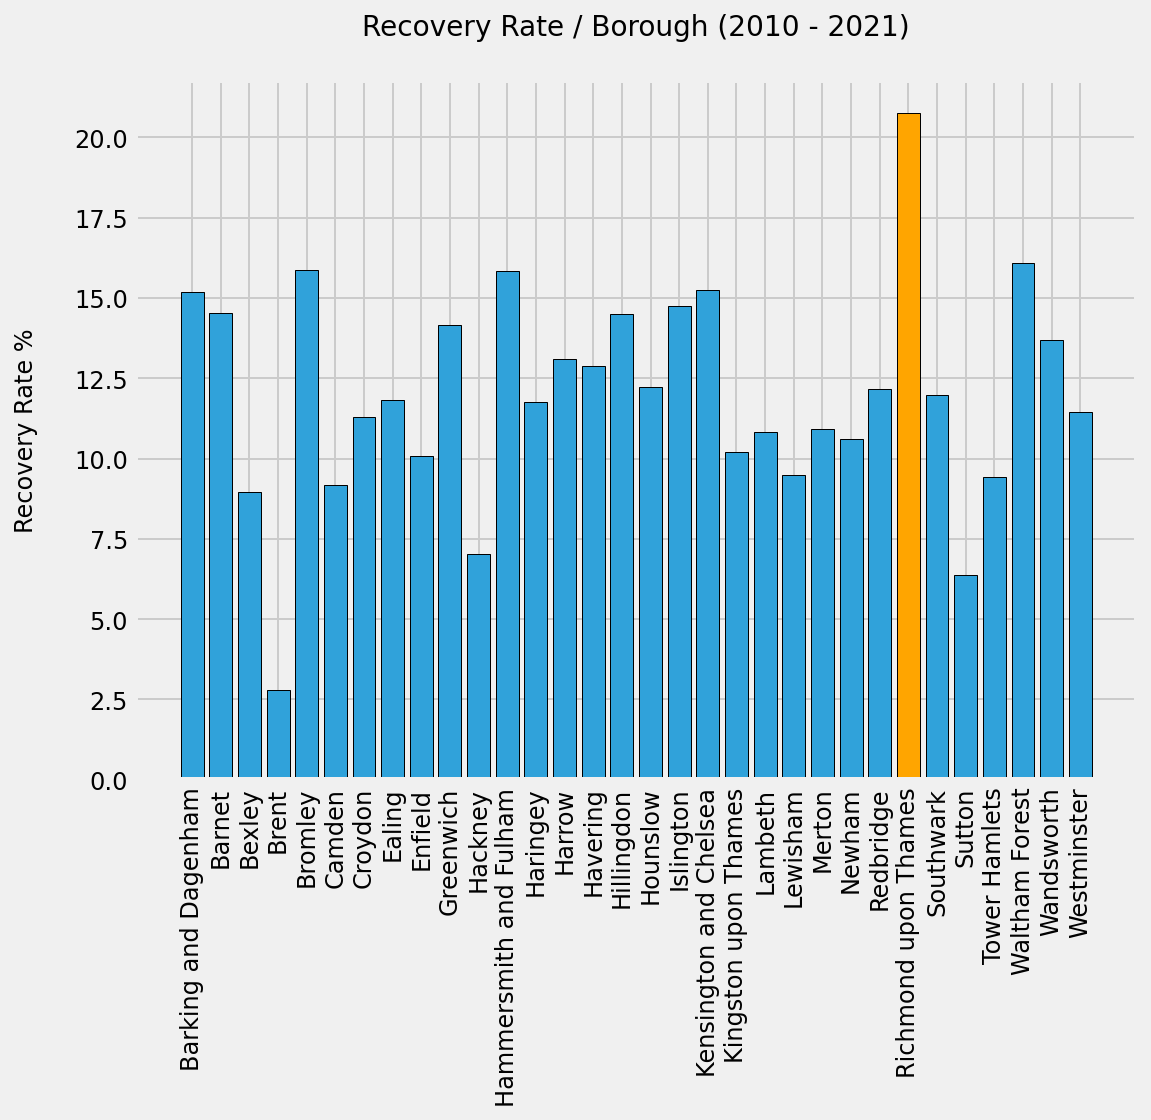

In [48]:
# Match values to groupby results
borough = [borough for borough, df in df.groupby('Borough')]

# Control color for highest Recovery Rate value
colors = np.where(results['Recovery Rate']==results['Recovery Rate'].max(), 'orange', '#30a2da')

plt.bar(borough, results['Recovery Rate'], ec='black', width=.8, color=colors)
plt.xticks(borough, fontweight=12, fontsize=12, rotation=90)
plt.yticks(fontweight=12, fontsize=12)
plt.ylabel('Recovery Rate %\n', fontweight=12, fontsize=12)
plt.ticklabel_format(axis='y', style='plain')
plt.title('Recovery Rate / Borough (2010 - 2021)\n', fontsize=14)
plt.show()

#### Q 5-4. London borough with the lowest recovery rate?

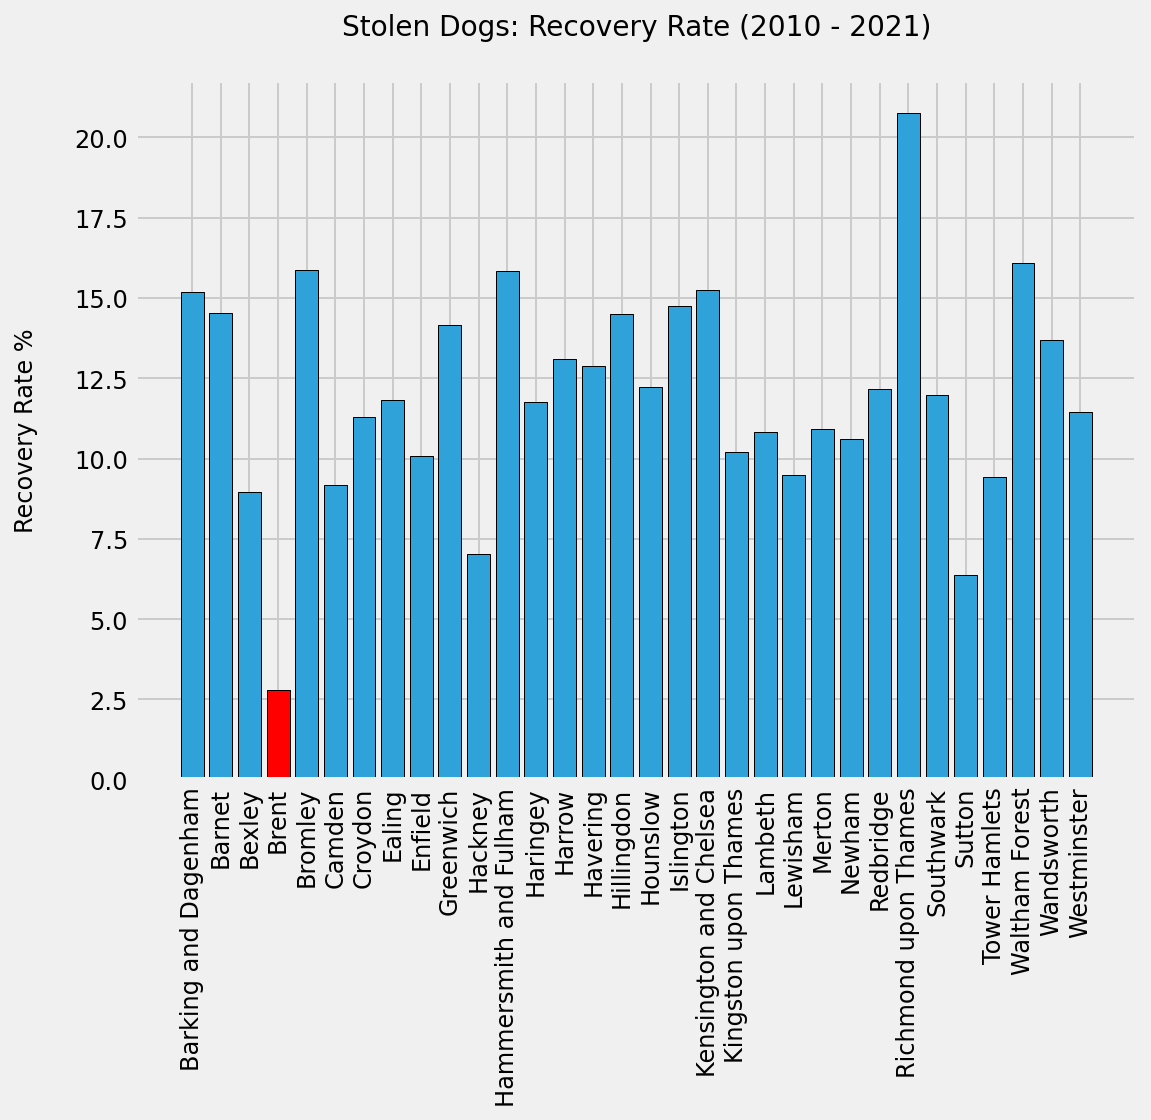

In [49]:
# Match values to groupby results
borough = [borough for borough, df in df.groupby('Borough')]

# Control color for lowest Recovery Rate value
colors2 = np.where(results['Recovery Rate']==results['Recovery Rate'].min(), 'red','#30a2da')

plt.bar(borough, results['Recovery Rate'], ec='black', width=.8, color=colors2)
plt.xticks(borough, fontweight=12, fontsize=12, rotation=90)
plt.yticks(fontweight=12, fontsize=12)
plt.ylabel('Recovery Rate %\n', fontweight=12, fontsize=12)
plt.ticklabel_format(axis='y', style='plain')
plt.title('Stolen Dogs: Recovery Rate (2010 - 2021)\n', fontsize=14)
plt.show()

### Part 6. GEO <a class="anchor" id="section6"></a>

- geopandas

- `ref: statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp`

In [50]:
# Add Borough Name column to original DataFrame
df['Borough Name'] = df['Borough']

df.head(3)

,Borough,Location,Total Stolen,Recovered,Total Recovered,Month,Year,Borough Name
0,Lambeth,Inner London,1,Not Recovered,0,1,2010,Lambeth
1,Croydon,Outer London,1,Not Recovered,0,1,2010,Croydon
2,Croydon,Outer London,1,Not Recovered,0,1,2010,Croydon


In [51]:
# Import GeoPandas
import geopandas as gpd

In [52]:
# Read shapefile to create a GeoDataFrame
dfGEO = gpd.read_file('data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
type(dfGEO)

geopandas.geodataframe.GeoDataFrame

In [53]:
# GeoDataFrame
dfGEO.head()

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


In [54]:
# Remove City of London from GeoDataFrame (avoids future errors)
name = ['City of London']
dfGEO = dfGEO[~dfGEO['NAME'].isin(name)]

In [55]:
# NOTE: geometry data set must include 'geometry' column
dfGEO.columns = [x.lower() for x in dfGEO.columns]
dfGEO.head()

,name,gss_code,hectares,nonld_area,ons_inner,sub_2009,sub_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.600 160201.800, 516407.300 16..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.200 159504.700, 535005.500 15..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.600 157530.400, 540361.200 15..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.800 178100.000, 521967.700 17..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.500 182881.600, 510249.900 18..."


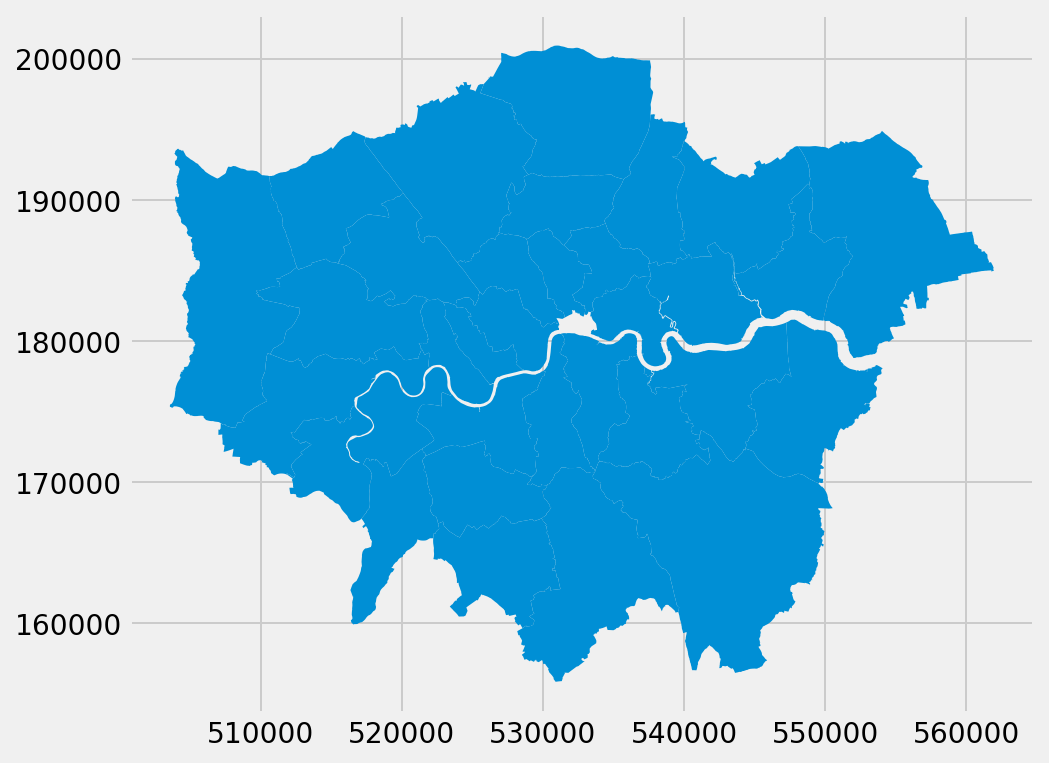

In [56]:
# Map preview
dfGEO.plot()
plt.show()

In [57]:
# Join original DataFrame to GeoDataFrame - dfMAP
dfMAP = dfGEO.set_index('name').join(df.set_index('Borough'))
dfMAP.head(3)

,gss_code,hectares,nonld_area,ons_inner,sub_2009,sub_2006,geometry,Location,Total Stolen,Recovered,Total Recovered,Month,Year,Borough Name
Barking and Dagenham,E09000002,3779.934,169.15,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",Outer London,1,Not Recovered,0,1,2010,Barking and Dagenham
Barking and Dagenham,E09000002,3779.934,169.15,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",Outer London,1,Not Recovered,0,1,2010,Barking and Dagenham
Barking and Dagenham,E09000002,3779.934,169.15,F,None,None,"MULTIPOLYGON (((543905.400 183199.100, 543905....",Outer London,1,Recovered,1,3,2010,Barking and Dagenham


In [58]:
# Add Borough Count column to GeoDataFrame
dfMAP['Borough Count'] = df['Borough'].value_counts()

# Set column Dtype to int
dfMAP['Borough Count'] = dfMAP['Borough Count'].astype(int)

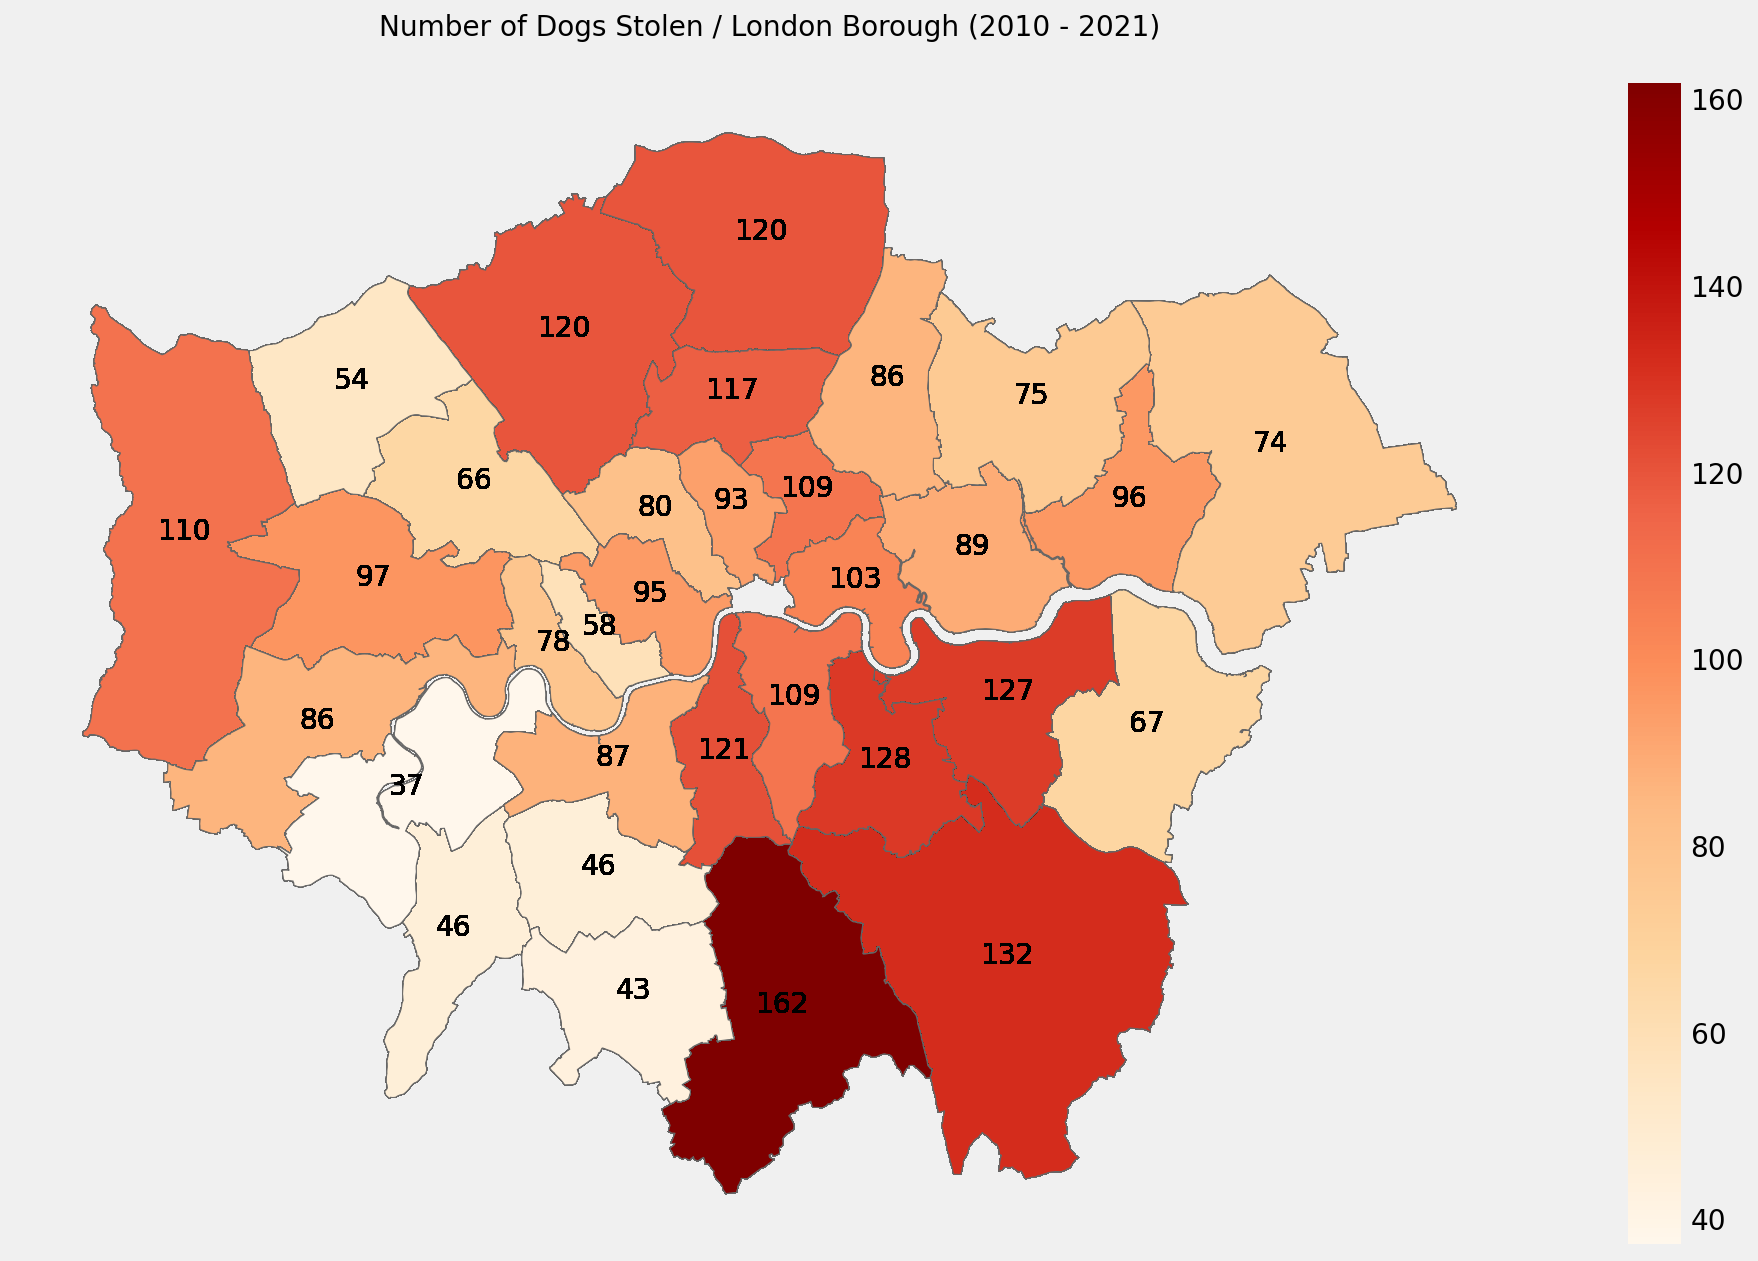

In [59]:
# Plot GeoDataFrame
ax = dfMAP.plot(column='Borough Count', cmap='OrRd', figsize=(16, 10), legend=True, ec='0.4')
plt.axis('off')
dfMAP.apply(lambda x: ax.annotate(text=x['Borough Count'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.title('Number of Dogs Stolen / London Borough (2010 - 2021)\n', fontsize=14)
plt.show()

#### 6-2. Additional Map

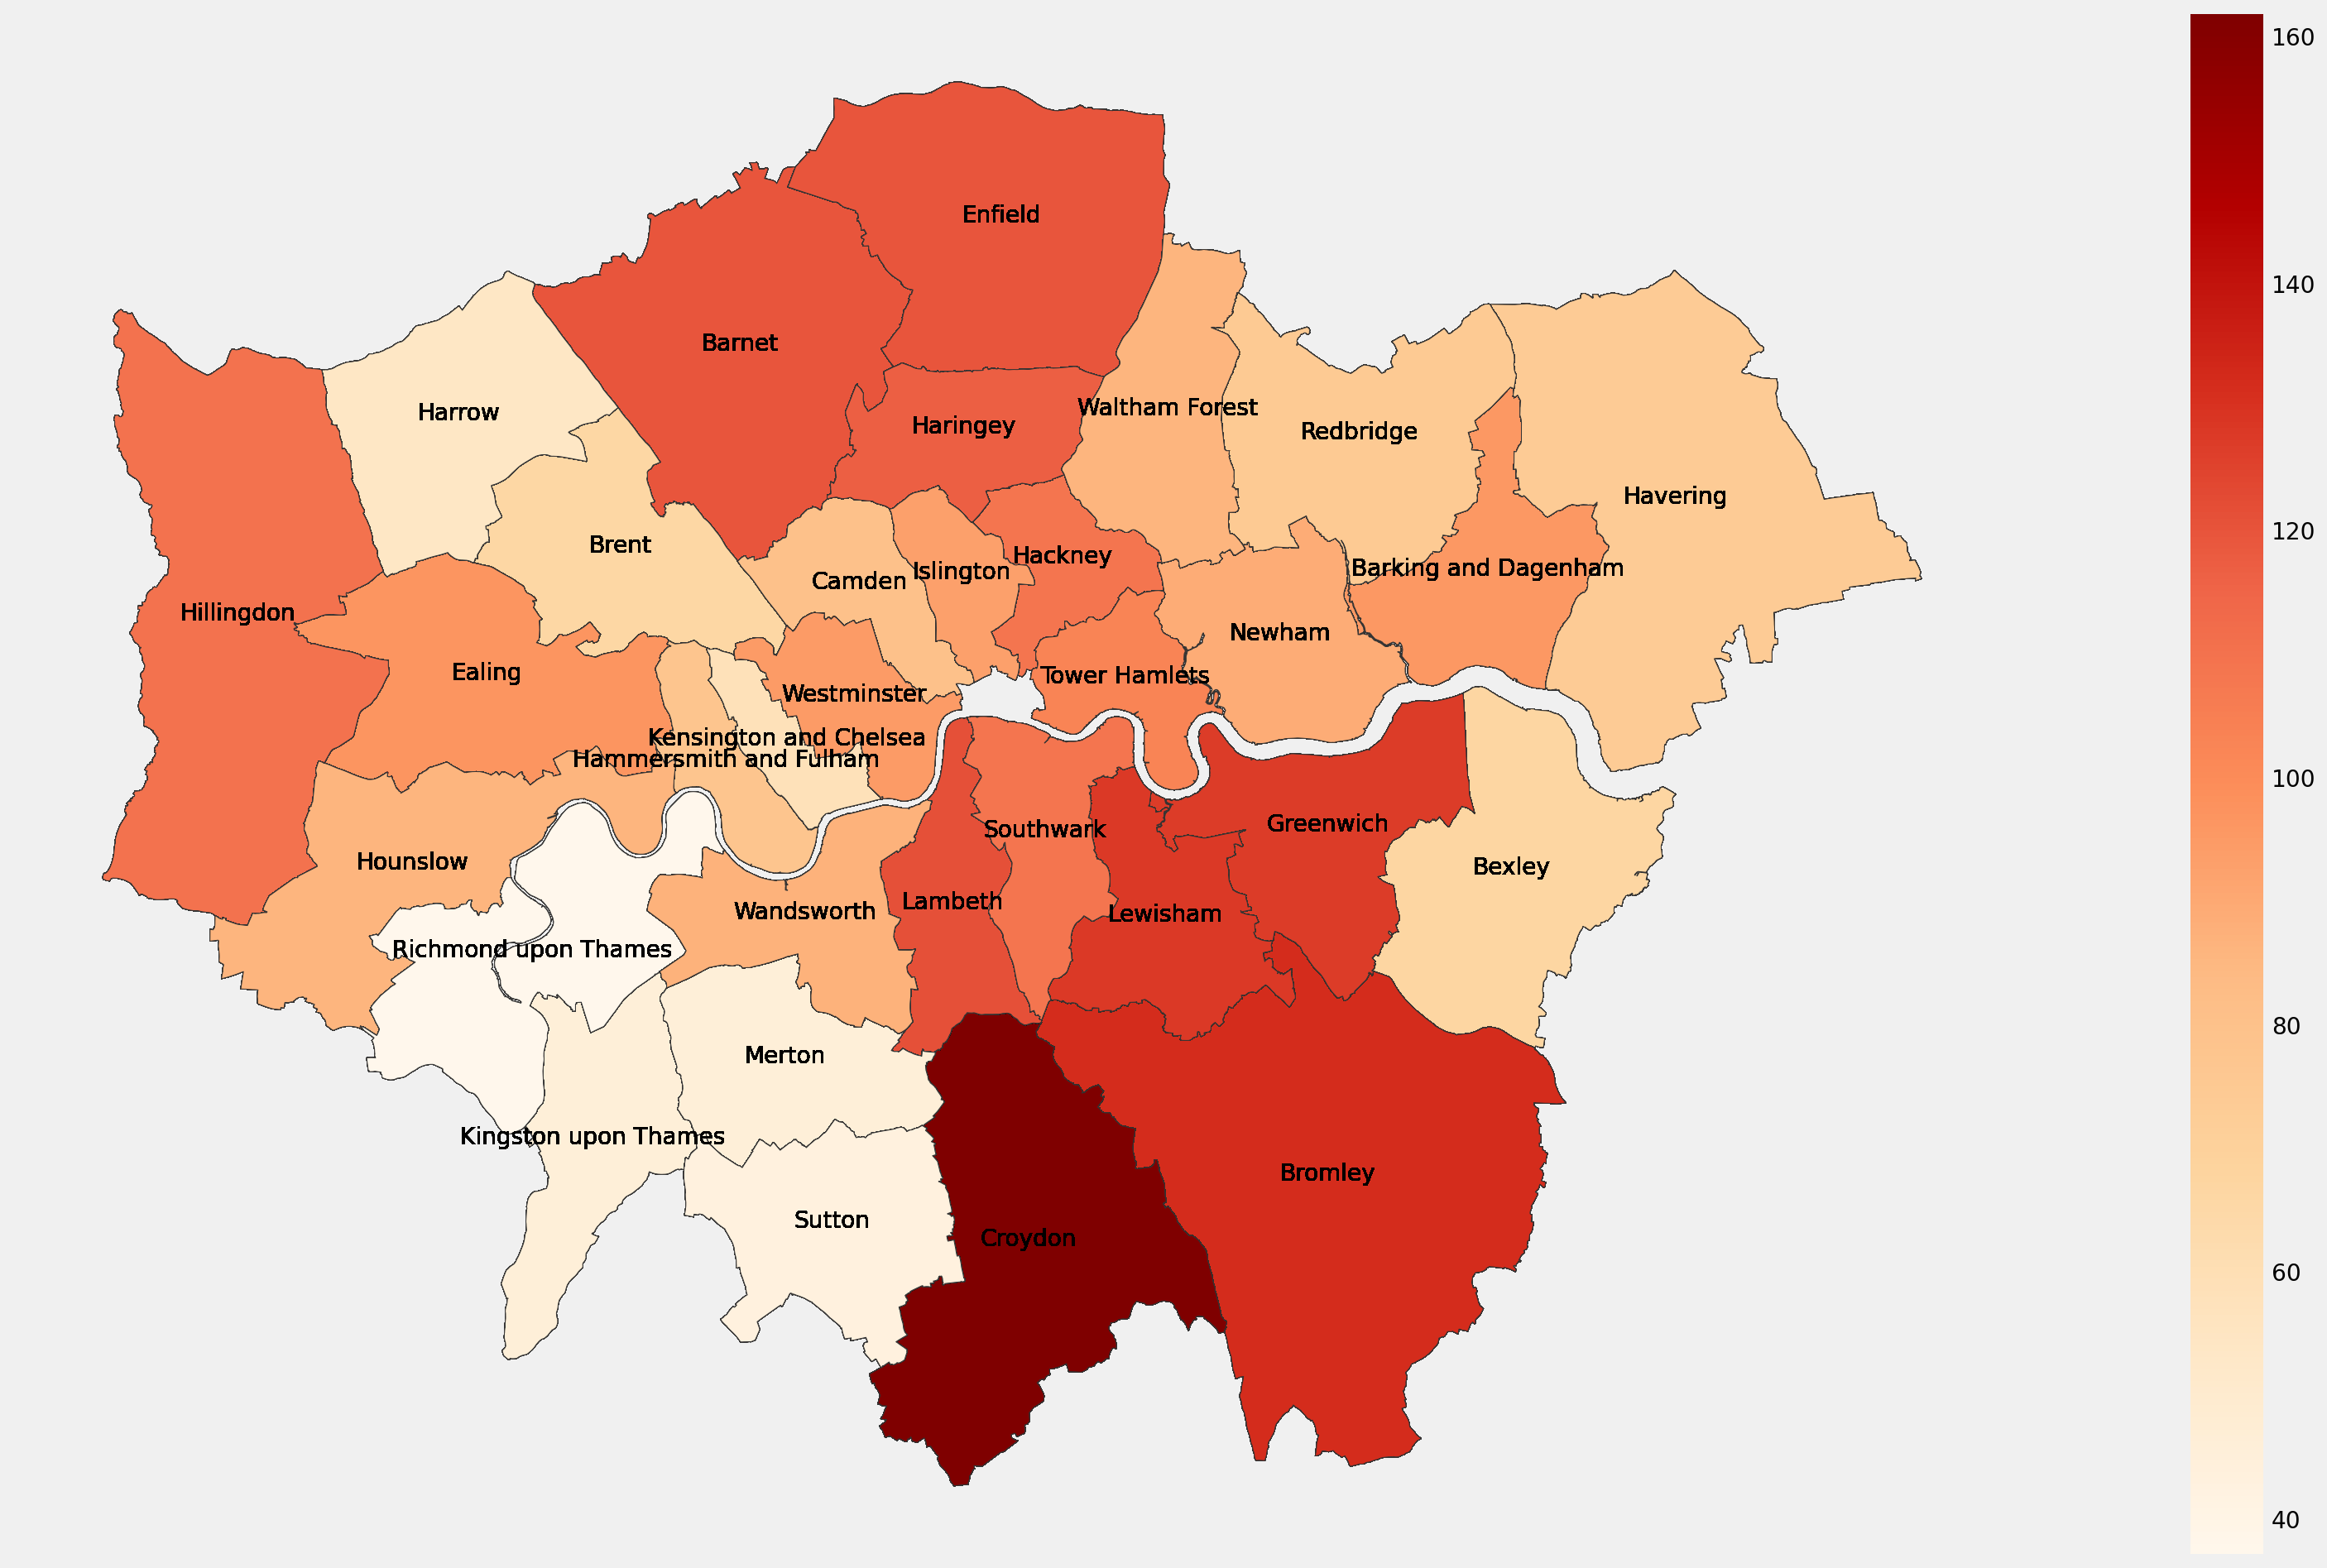

In [60]:
ax = dfMAP.plot(column='Borough Count', cmap='OrRd', figsize=(34, 16), legend=True, ec='0.2')
plt.axis('off')
dfMAP.apply(lambda x: ax.annotate(text=x['Borough Name'], xy=x.geometry.centroid.coords[0], ha='center'), axis=1)
plt.show()

[Return to contents](#sections)